In [1]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils
import numpy

In [2]:
## This piece of code is needed as I'm running the pyspark on virtual box
import pyspark
sc = pyspark.SparkContext()

### Higgs data set
* **URL:** http://archive.ics.uci.edu/ml/datasets/HIGGS#  
* **Abstract:** This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not.

**Data Set Information:**  
The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.



In [3]:
!pwd

/home/jovyan/work/DSE/Q3_DSE230 - Data analysis using Spark/Day 4/Assignment/HW-5/Final


In [4]:
%cd /home/jovyan/work/DSE/Q3_DSE230 - Data analysis using Spark/Day 4/Assignment/Data

/home/jovyan/work/DSE/Q3_DSE230 - Data analysis using Spark/Day 4/Assignment/Data


In [5]:
#Change this variable to point to the location of the github repository on your computer
Root_dir="/home/jovyan/work/DSE/Q3_DSE230 - Data analysis using Spark/Day 4/Assignment/Data"

In [6]:
#define feature names
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[strip(a) for a in split(feature_text,',')]
print len(features),features

28 ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [7]:
# create a directory called higgs, download and decompress HIGGS.csv.gz into it

from os.path import exists
if not exists('higgs'):
    print "creating directory higgs"
    !mkdir higgs
%cd higgs
if not exists('HIGGS.csv'):
    if not exists('HIGGS.csv.gz'):
        print 'downloading HIGGS.csv.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
    print 'decompressing HIGGS.csv.gz --- May take 5-10 minutes'
    !gunzip -f HIGGS.csv.gz
!ls -l
%cd ..

/home/jovyan/work/DSE/Q3_DSE230 - Data analysis using Spark/Day 4/Assignment/Data/higgs
total 7847168
-rw-r--r-- 1 jovyan staff 8035497980 May 20 01:42 HIGGS.csv
/home/jovyan/work/DSE/Q3_DSE230 - Data analysis using Spark/Day 4/Assignment/Data


### As done in previous notebook, create RDDs from raw data and build Gradient boosting and Random forests models. Consider doing 1% sampling since the dataset is too big for your local machine

In [8]:
# Have a look at the first two lines of the data file
!head -2 higgs/HIGGS.csv

1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
1.000000000000000000e+00,9.075421094894409180e-01,3.291472792625427246e-01,3.594118654727935791e-01,1.497969865798950195e+00,-3.130095303058624268e-01,1.095530629158020020e+00,-5.575249195098876953e-01,-1.588229775428771973e+00,2.173076152801513672e+00,8.12581181526

In [9]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='/home/jovyan/work/DSE/Q3_DSE230 - Data analysis using Spark/Day 4/Assignment/Data/higgs/HIGGS.csv'
inputRDD=sc.textFile(path)
inputRDD.first()

u'1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01'

In [10]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')]).map(lambda x: LabeledPoint(x[0],x[1:])) ## Fillin##
Data.take(5)

[LabeledPoint(1.0, [0.869293212891,-0.635081827641,0.22569026053,0.327470064163,-0.689993202686,0.754202246666,-0.24857313931,-1.09206390381,0.0,1.37499213219,-0.653674185276,0.930349111557,1.10743606091,1.13890433311,-1.57819831371,-1.0469853878,0.0,0.65792953968,-0.0104545699432,-0.0457671694458,3.10196137428,1.35376000404,0.979563117027,0.978076159954,0.920004844666,0.721657454967,0.988750934601,0.876678347588]),
 LabeledPoint(1.0, [0.907542109489,0.329147279263,0.359411865473,1.4979698658,-0.313009530306,1.09553062916,-0.55752491951,-1.58822977543,2.1730761528,0.812581181526,-0.213641926646,1.27101457119,2.21487212181,0.499993950129,-1.26143181324,0.732156157494,0.0,0.398700892925,-1.13893008232,-0.000819110195152,0.0,0.302219897509,0.833048164845,0.985699653625,0.978098392487,0.779732167721,0.992355763912,0.798342585564]),
 LabeledPoint(1.0, [0.798834741116,1.47063875198,-1.63597476482,0.45377317071,0.425629168749,1.1048746109,1.28232228756,1.38166427612,0.0,0.851737201214,1.54065

In [11]:
# Reduce the data size (Using 0.1% of the data due to my system limitations)

Data1=Data.sample(False,0.001).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=11082, trainingData=7702, testData=3380


In [12]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(1.0, 1747), (0.0, 1633)]

## Gradient Boost

##### In the following section I have implemented Gradient Boost algorithm. Since I have used just 0.1% of the data, it was hard to get a good error rate or fit. I have run into the issue of overfitting due to lack of data. However, I was able to get good results on pybolt.

### Note: Since I am using a very small slice (0.1%) of data on the local machine due to system limitations, it is hard to tune the model to achieve lesser than 30% error. 

In [13]:
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData,categoricalFeaturesInfo={} ,numIterations=10,maxDepth = depth,learningRate=0.6)
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda x: x.label).zip(Predicted) ### FILLIN ###
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.3464497041420118, 'train': 0.33251103609452093} 59 seconds
3 {'test': 0.3272189349112426, 'train': 0.2804466372370813} 67 seconds
6 {'test': 0.3437869822485207, 'train': 0.16060763438068035} 98 seconds
10 {'test': 0.3591715976331361, 'train': 0.00038950921838483513} 306 seconds
{1: {'test': 0.3464497041420118, 'train': 0.33251103609452093}, 10: {'test': 0.3591715976331361, 'train': 0.00038950921838483513}, 3: {'test': 0.3272189349112426, 'train': 0.2804466372370813}, 6: {'test': 0.3437869822485207, 'train': 0.16060763438068035}}


In [14]:
B10 = errors

In [15]:
%cd /home/jovyan/work/DSE/Q3_DSE230 - Data analysis using Spark/Day 4/Assignment/HW-5

/home/jovyan/work/DSE/Q3_DSE230 - Data analysis using Spark/Day 4/Assignment/HW-5


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


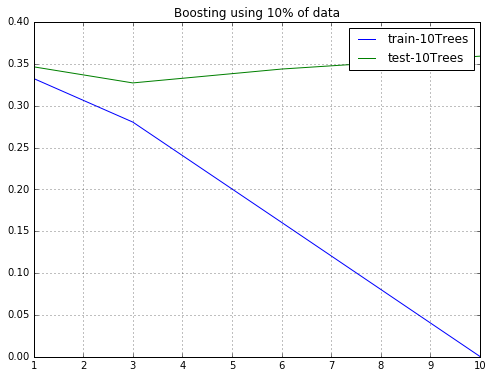

In [16]:
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

## Random Forest 

##### In the following section I have implemented Random Forest algorithm. Since I have used just 0.1% of the data, it was hard to get a good error rate or fit. I have run into the issue of overfitting due to lack of data. However, I was able to get good results on pybolt.

### Note: Since I am using a very small slice (0.1%) of data on the local machine due to system limitations, it is hard to tune the model to achieve lesser than 30% error. 

In [17]:
from time import time
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData,categoricalFeaturesInfo={},numTrees=10,maxDepth=depth,
                                         impurity='gini',featureSubsetStrategy="auto",numClasses=2)
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda x: x.label).zip(Predicted) ### FILLIN ###
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.40857988165680476, 'train': 0.40067514931186704} 32 seconds
3 {'test': 0.40059171597633136, 'train': 0.3858737990132433} 34 seconds
6 {'test': 0.3467455621301775, 'train': 0.3083614645546611} 45 seconds
10 {'test': 0.34142011834319524, 'train': 0.1668397818748377} 72 seconds
15 {'test': 0.3505917159763314, 'train': 0.04167748636717736} 114 seconds
20 {'test': 0.3488165680473373, 'train': 0.014541677486367177} 149 seconds
{1: {'test': 0.40857988165680476, 'train': 0.40067514931186704}, 3: {'test': 0.40059171597633136, 'train': 0.3858737990132433}, 6: {'test': 0.3467455621301775, 'train': 0.3083614645546611}, 10: {'test': 0.34142011834319524, 'train': 0.1668397818748377}, 15: {'test': 0.3505917159763314, 'train': 0.04167748636717736}, 20: {'test': 0.3488165680473373, 'train': 0.014541677486367177}}


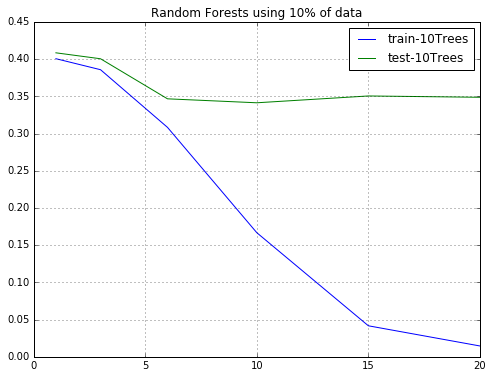

In [18]:
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')

### Now plot B10 and RF_10trees performance curves in the same graph

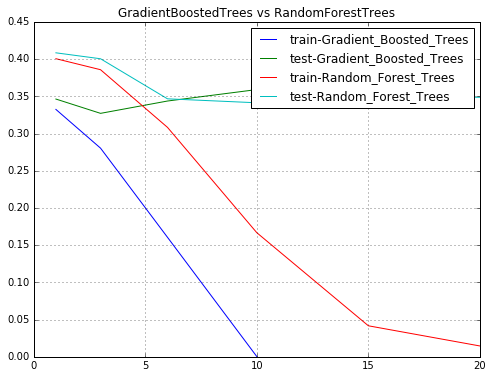

In [19]:
make_figure([B10, RF_10trees],['Gradient_Boosted_Trees', 'Random_Forest_Trees'],\
                Title='GradientBoostedTrees vs RandomForestTrees')